In [1]:
# import useful packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import power_transform
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

In [2]:
# define some function and parameters to train

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

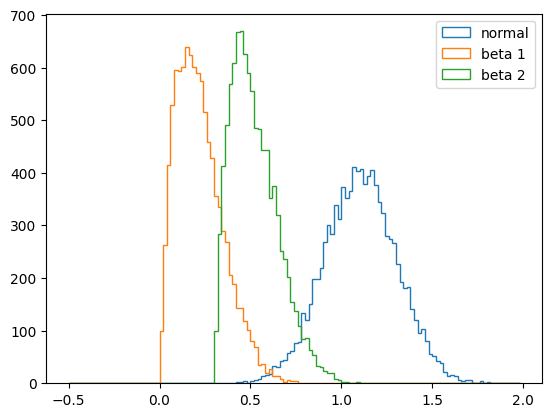

In [3]:
# base on normal and beta distribution to randomly produce lots of fake samples
normal = np.random.normal(1, 0.2, 10000) + 0.1
beta_1 = np.random.beta(2, 7, 10000)
beta_2 = np.random.beta(2, 7, 10000) + 0.3

# visualization
plt.figure()
tim_bin = np.arange(-0.5, 2, 0.02)
plt.hist(normal, bins=tim_bin, histtype='step', label='normal')
plt.hist(beta_1, bins=tim_bin, histtype='step', label='beta 1')
plt.hist(beta_2, bins=tim_bin, histtype='step', label='beta 2')
plt.legend()
plt.show()

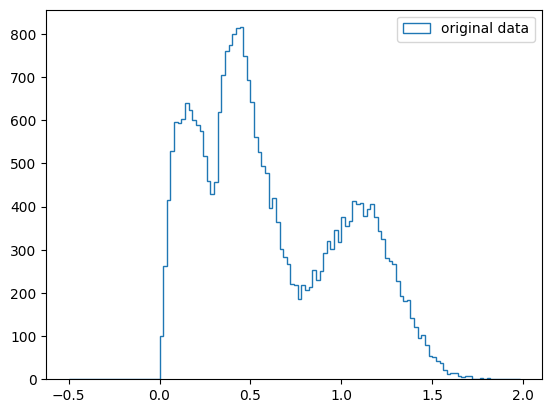

In [4]:
# combine 3 components to become the fake light curve
beta_12_normal = np.concatenate((beta_1, beta_2, normal), axis=0)

# visualization
plt.figure()
tim_bin = np.arange(-0.5, 2, 0.02)
plt.hist(beta_12_normal, bins=tim_bin, histtype='step', label='original data')
plt.legend()
plt.show()

,Number of components,Type of covariance,BIC score
4,5,spherical,8504.295871
16,5,diag,8524.727871
22,5,full,8537.212395
17,6,diag,8568.735352
21,4,full,8572.885253
23,6,full,8573.374754
5,6,spherical,8577.215209
15,4,diag,8583.131383
3,4,spherical,8587.342382
7,2,tied,8617.491592


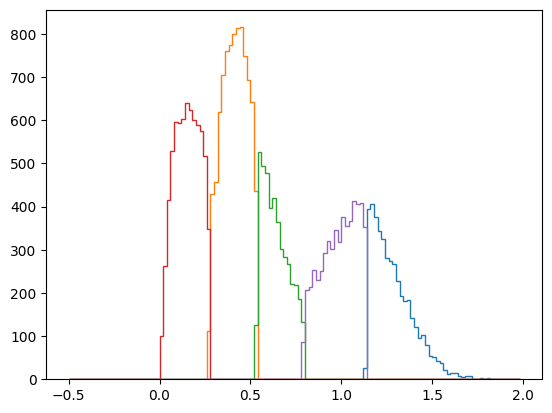

In [5]:
# select data to train and predict
x = beta_12_normal
train_x = x.reshape(-1, 1)

# initialise the training model
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)

# training
grid_search.fit(train_x)

# collect best fitting results in df
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"] # recover the BIC score
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)

# display df sorted by BIC score
display(df.sort_values(by="BIC score"))

# get the best fit prediction
train_x_label = grid_search.best_estimator_.predict(train_x).flatten()

# visualization
plt.figure()
tim_bin = np.arange(-0.5, 2, 0.02)
for component in range(grid_search.best_params_['n_components']):
    clustered_data = [x_data for x_data_index, x_data in enumerate(x) if train_x_label[x_data_index]==component]
    plt.hist(clustered_data, bins=tim_bin, histtype='step')
plt.show()

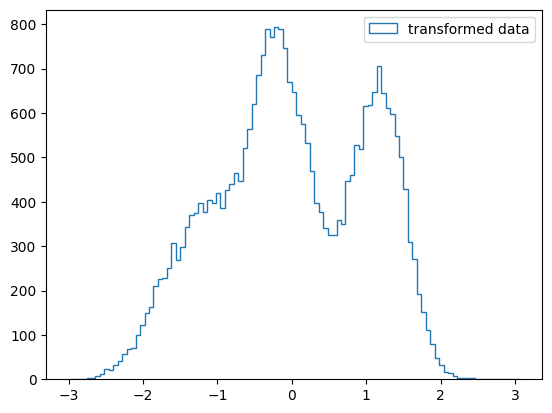

In [6]:
# do the box-cox transformation
beta_12_normal_transformed = power_transform(beta_12_normal.reshape(-1, 1), method='box-cox').flatten()

# use KDE to get PDF to produce lots of fake samples 
beta_12_normal_transformed_kde = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(beta_12_normal_transformed.reshape(-1, 1))
beta_12_normal_transformed_kde2pdf_samples = beta_12_normal_transformed_kde.sample(n_samples=30000).flatten()

# visualization
plt.figure()
min_int = np.floor(np.min(beta_12_normal_transformed_kde2pdf_samples))
max_int = np.ceil(np.max(beta_12_normal_transformed_kde2pdf_samples))
binsize = (max_int - min_int)/100
tim_bin = np.arange(min_int, max_int+binsize, binsize)
plt.hist(beta_12_normal_transformed_kde2pdf_samples, bins=tim_bin, histtype='step', label='transformed data')
plt.legend()
plt.show()

,Number of components,Type of covariance,BIC score
20,3,full,16292.783893
14,3,diag,16293.085778
2,3,spherical,16293.251235
8,3,tied,16320.658728
21,4,full,16336.191363
15,4,diag,16336.230203
3,4,spherical,16337.487713
10,5,tied,16337.746809
9,4,tied,16345.442471
11,6,tied,16347.645033


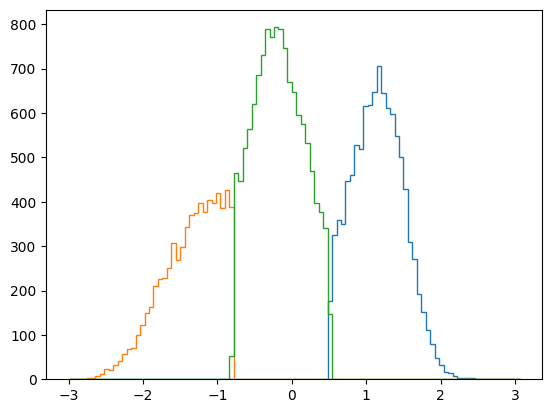

In [7]:
# select data to train and predict
x = beta_12_normal_transformed_kde2pdf_samples
train_x = x.reshape(-1, 1)

# initialise the training model
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)

# training
grid_search.fit(train_x)

# collect best fitting results in df
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"] # recover the BIC score
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)

# display df sorted by BIC score
display(df.sort_values(by="BIC score"))

# get the best fit prediction
train_x_label = grid_search.best_estimator_.predict(train_x).flatten()

# visualization
plt.figure()
min_int = np.floor(np.min(beta_12_normal_transformed_kde2pdf_samples))
max_int = np.ceil(np.max(beta_12_normal_transformed_kde2pdf_samples))
binsize = (max_int - min_int)/100
tim_bin = np.arange(min_int, max_int+binsize, binsize)
for component in range(grid_search.best_params_['n_components']):
    clustered_data = [x_data for x_data_index, x_data in enumerate(x) if train_x_label[x_data_index]==component]
    plt.hist(clustered_data, bins=tim_bin, histtype='step')
plt.show()

In [8]:
# load data in .npz file
container = np.load('src_pdf_data.npz')

# transfer data to dictionary
src_dic = {name: container[name] for name in container}

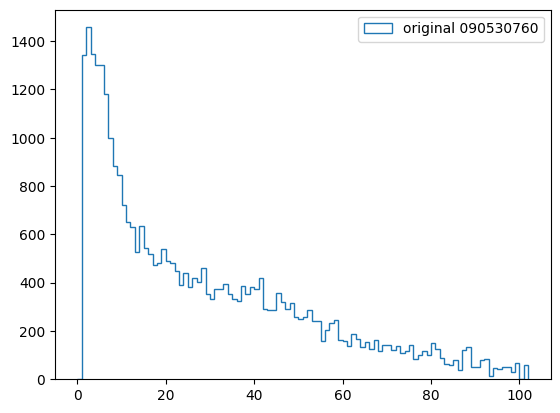

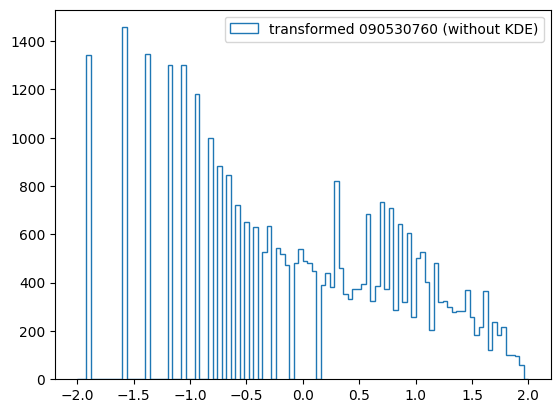

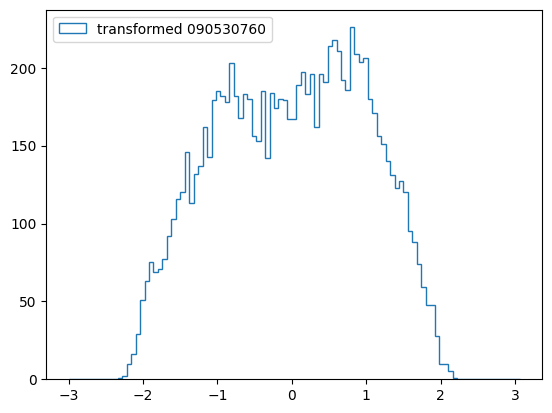

,Number of components,Type of covariance,BIC score
7,2,tied,5521.693220
8,3,tied,5521.761571
10,5,tied,5524.437366
9,4,tied,5528.327301
19,2,full,5529.266975
1,2,spherical,5529.282753
13,2,diag,5529.394526
2,3,spherical,5534.681483
14,3,diag,5535.395238
20,3,full,5535.930680


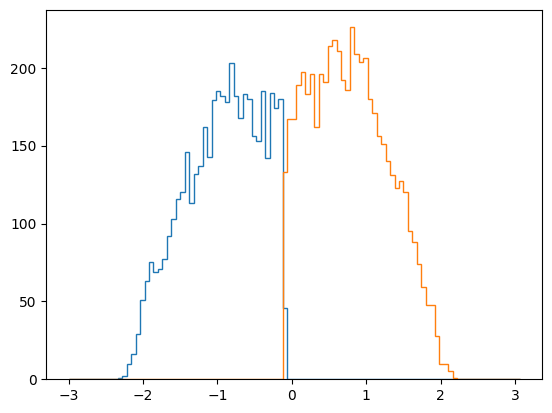

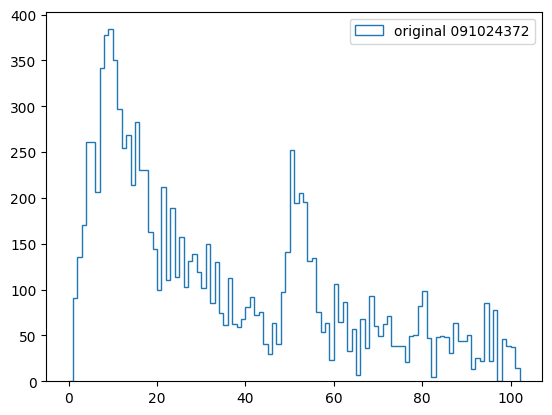

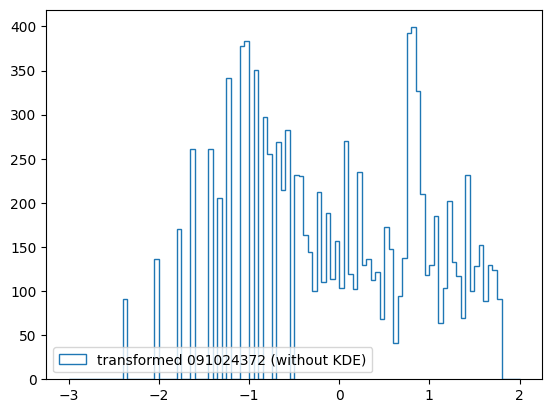

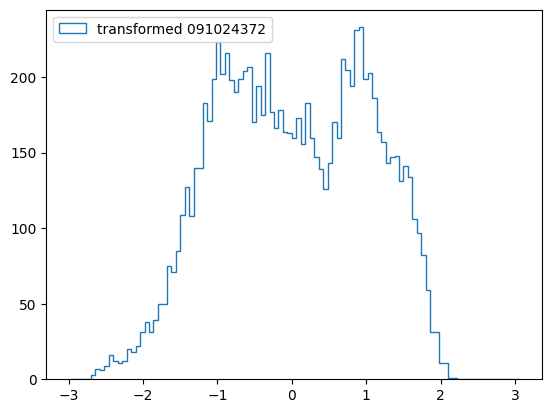

,Number of components,Type of covariance,BIC score
19,2,full,5551.258423
1,2,spherical,5551.353005
13,2,diag,5551.359470
7,2,tied,5557.062752
8,3,tied,5561.037778
14,3,diag,5565.748776
20,3,full,5565.963681
2,3,spherical,5566.184561
10,5,tied,5575.047262
11,6,tied,5575.637696


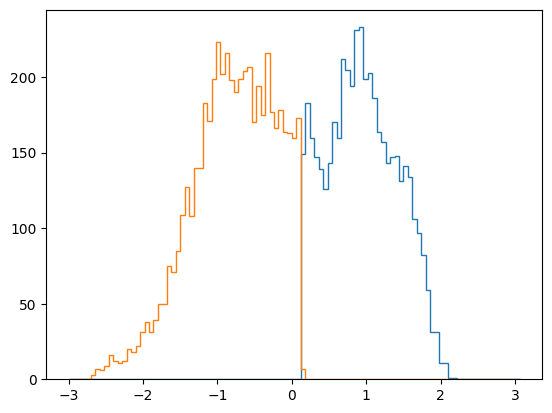

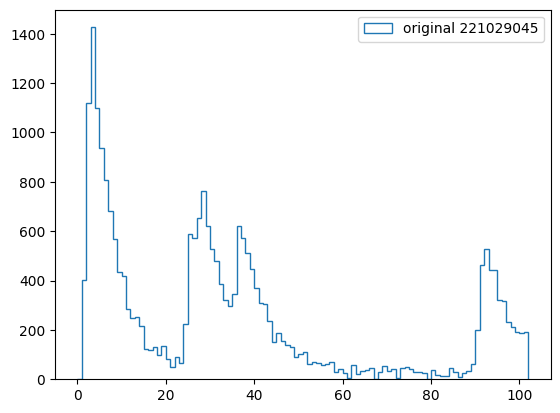

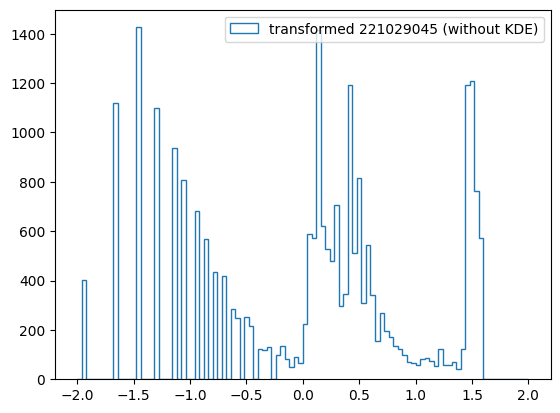

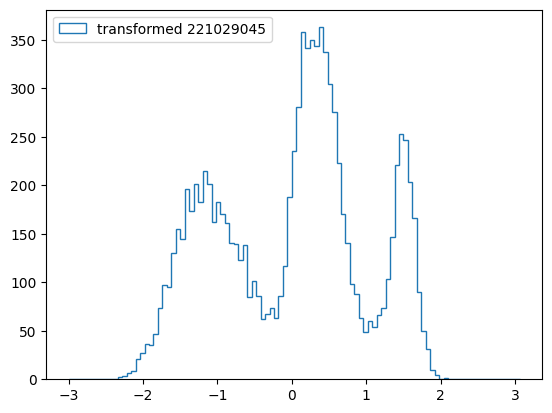

,Number of components,Type of covariance,BIC score
14,3,diag,4924.793031
2,3,spherical,4924.793096
20,3,full,4924.799400
21,4,full,4941.814727
15,4,diag,4941.855366
3,4,spherical,4941.996867
4,5,spherical,4966.980318
16,5,diag,4967.084559
22,5,full,4967.101035
23,6,full,4989.020921


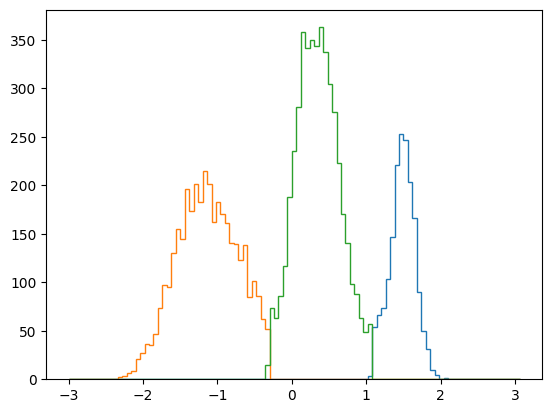

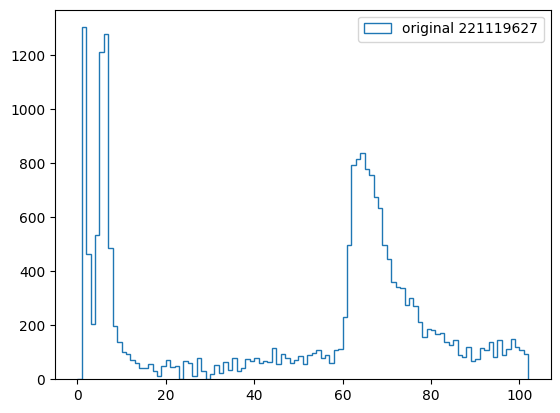

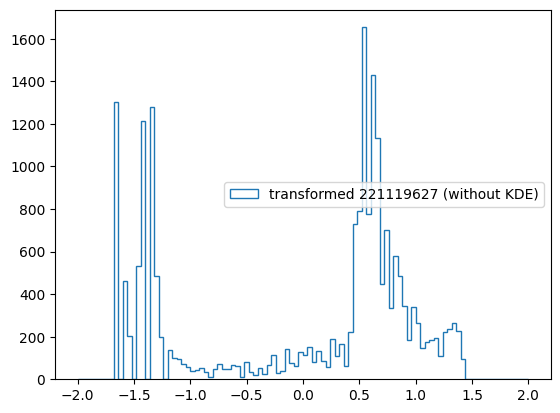

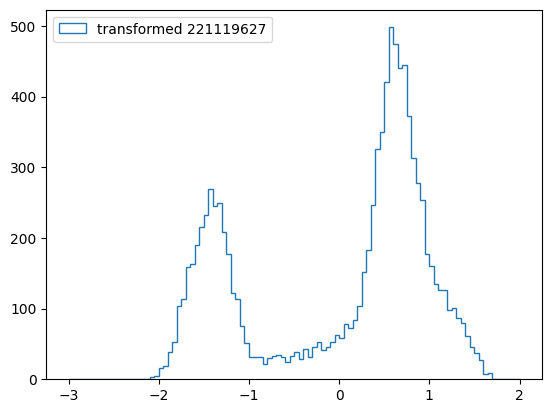

,Number of components,Type of covariance,BIC score
15,4,diag,3846.589933
3,4,spherical,3846.793091
21,4,full,3847.107246
9,4,tied,3847.371555
10,5,tied,3854.387358
4,5,spherical,3865.244028
11,6,tied,3872.741841
22,5,full,3872.825564
16,5,diag,3873.045473
23,6,full,3892.519617


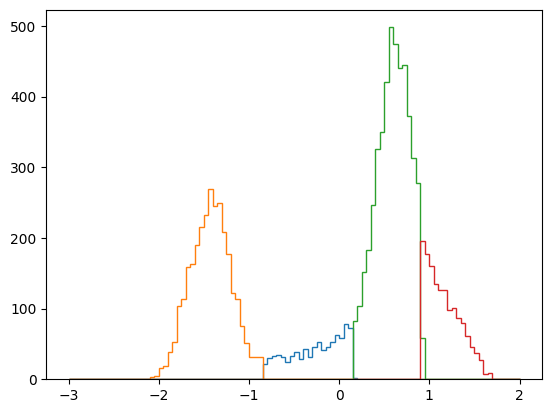

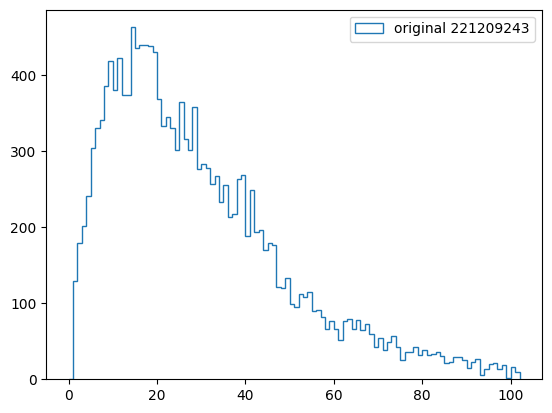

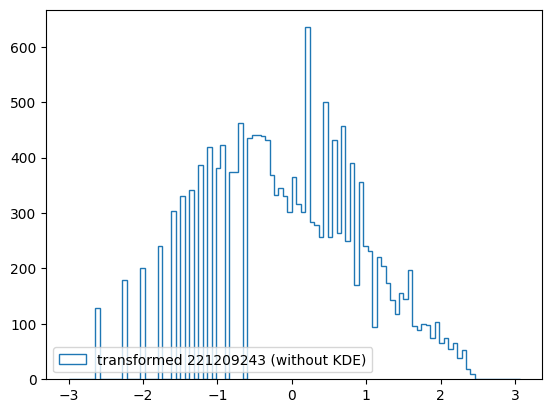

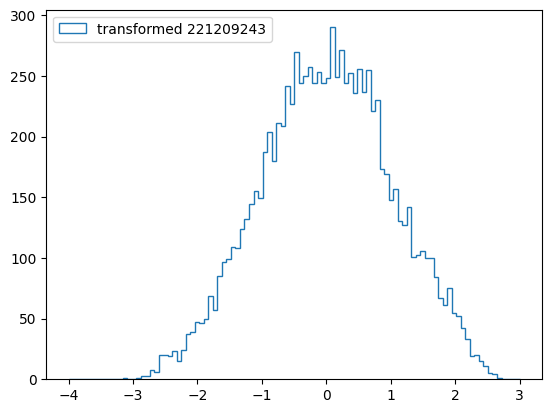

,Number of components,Type of covariance,BIC score
0,1,spherical,5752.962208
12,1,diag,5752.962208
6,1,tied,5752.962208
18,1,full,5752.962208
7,2,tied,5759.491908
19,2,full,5766.870606
1,2,spherical,5766.959843
13,2,diag,5766.964816
8,3,tied,5770.036715
9,4,tied,5777.306462


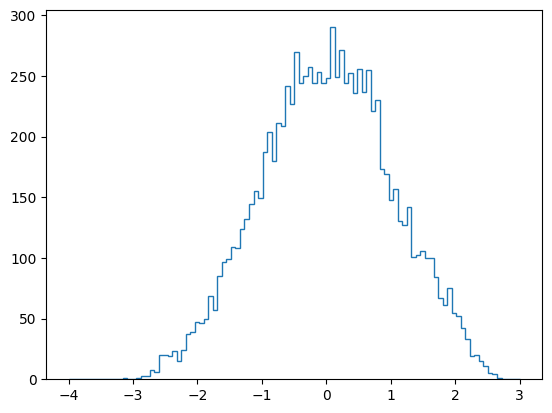

In [18]:
# setup some cases to check
view_list = ['090530760', '091024372', '221029045', '221119627', '221209243']

for key in src_dic:
    if key in view_list:
        # shift 1 to avoid 0 issue
        data = src_dic[key] + 1
        
        # visualize original data
        plt.figure()
        tim_bin = np.arange(0, 100+3, 1)
        plt.hist(data, bins=tim_bin, histtype='step', label=f'original {key}')
        plt.legend()
        plt.show()
        
        # do the box-cox transformation
        data_transformed = power_transform(data.reshape(-1, 1), method='box-cox').flatten()
        
        # use KDE to get PDF to produce lots of fake samples 
        data_transformed_kde = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(data_transformed.reshape(-1, 1))
        data_transformed_kde2pdf_samples = data_transformed_kde.sample(n_samples=10000).flatten()

        # visualization transformed data (without KDE processing)
        plt.figure()
        min_int = np.floor(np.min(data_transformed))
        max_int = np.ceil(np.max(data_transformed))
        binsize = (max_int - min_int)/100
        tim_bin = np.arange(min_int, max_int+binsize, binsize)
        plt.hist(data_transformed, bins=tim_bin, histtype='step', label=f'transformed {key} (without KDE)')
        plt.legend()
        plt.show()
        
        # visualization transformed data
        plt.figure()
        min_int = np.floor(np.min(data_transformed_kde2pdf_samples))
        max_int = np.ceil(np.max(data_transformed_kde2pdf_samples))
        binsize = (max_int - min_int)/100
        tim_bin = np.arange(min_int, max_int+binsize, binsize)
        plt.hist(data_transformed_kde2pdf_samples, bins=tim_bin, histtype='step', label=f'transformed {key}')
        plt.legend()
        plt.show()
        
        # select data to train and predict
        x = data_transformed_kde2pdf_samples
        train_x = x.reshape(-1, 1)

        # initialise the training model
        grid_search = GridSearchCV(
            GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
        )

        # training
        grid_search.fit(train_x)

        # collect best fitting results in df
        df = pd.DataFrame(grid_search.cv_results_)[
            ["param_n_components", "param_covariance_type", "mean_test_score"]
        ]
        df["mean_test_score"] = -df["mean_test_score"] # recover the BIC score
        df = df.rename(
            columns={
                "param_n_components": "Number of components",
                "param_covariance_type": "Type of covariance",
                "mean_test_score": "BIC score",
            }
        )

        # display df sorted by BIC score
        display(df.sort_values(by="BIC score"))

        # get the best fit prediction
        train_x_label = grid_search.best_estimator_.predict(train_x).flatten()

        # visualization
        plt.figure()
        for component in range(grid_search.best_params_['n_components']):
            clustered_data = [x_data for x_data_index, x_data in enumerate(x) if train_x_label[x_data_index]==component]
            plt.hist(clustered_data, bins=tim_bin, histtype='step')
        plt.show()